Written by Zain Kamal [zain.eris.kamal@rutgers.edu](mailto:zain.eris.kamal@rutgers.edu) on 06/24/2023.

https://github.com/Humboldt-Penguin/redplanet

---
# 1. Raw Data Work

In [6]:
from redplanet import utils
path__rpDataHome = r'C:\Users\Eris\Downloads\redplanet_development'

path__rawDataDir = utils.getPath(path__rpDataHome, 'GRS', '1_raw') # raw data should already be downloaded into this directory from https://digitalcommons.lsu.edu/geo_psl/1/

In [2]:
"""imports"""

import os

import numpy as np


"""initialize values"""

nanval = -1e10
# Value given to pixels where data is not defined (i.e. "NOT_APPLICABLE_CONSTANT"). In the data, this is 9999.999 (see lbl file).

def get_nanval():
    return nanval


meta_dat = {}
'''
`meta_dat` is formatted as `meta_dat[element_name][quantity]`, where
    - `element_name` is from ['cl','fe','h2o','k','kvsth','si','th']
    - `quantity` is from:
        - 'concentration' = Concentration of the element. 
        - 'sigma' = The error associated with the concentration measurement. 

Calling `meta_dat` as such gives an NxM numpy array, where N and M correspond to values in `lon_range` and `lat_range` respectively.
'''






"""we hardcode these values because know the data is 5x5 degree grid"""
grid_spacing = 5 # degrees
lat_range = np.arange(87.5, -87.5 *1.0001, -grid_spacing)
lon_range = np.arange(177.5, -177.5 *1.0001, -grid_spacing)
lon_range_cycled = np.arange(182.5, -182.5 *1.0001, -grid_spacing)






"""load + format data"""

filenames = os.listdir(path__rawDataDir)
# filename = 'Th_GS2010_5x5.txt'

for filename in filenames:
    if 'README' in filename: continue




    '''initialize entry in `meta_dat`'''
    element_name = filename[:filename.index('_')].lower()
    meta_dat[element_name] = {}



    '''import data from files to np.ndarrays'''
    dat = np.loadtxt(utils.getPath(path__rawDataDir,filename), skiprows=1)  
    dat = np.where(dat == 9999.999, nanval, dat)


    """ ==> we hardcode these values because know the data is 5x5 degree grid
    lat_range = utils.unique(dat[:, 0])
    lon_range = utils.unique(dat[:, 1])

    if len(np.unique(np.diff(lon_range).round(decimals=3))) != 1:
        raise Exception('Longitude values are not evenly spaced. This is not supported by the interpolation model.')
    if len(np.unique(np.diff(lat_range).round(decimals=3))) != 1:
        raise Exception('Latitude values are not evenly spaced. This is not supported by the interpolation model.')

    '''edge case (part 1/2): longitude is cyclical, but data is not, so we duplicate one extra column on each edge of data & lon_range'''
    grid_spacing = np.unique(np.diff(lon_range).round(decimals=3))[0] # grid_spacing based on lon values, so it might be negative if lon is decreasing. but this is okay, it allows the lon cycling to work out.
    meta_dat[element_name]['grid spacing [degrees]'] = abs(grid_spacing)
    lon_range_cycled = np.array([lon_range[0]-grid_spacing, *lon_range, lon_range[-1]+grid_spacing]) # even if grid_spacing is negative, this will work out.
    """


    data_names = ['concentration', 'sigma']

    for i in range(len(data_names)):
        this_data = dat[:, i+2]
        
        '''reshape to 2D, transpose to get [lon,lat] indexing'''
        this_data = this_data.reshape(lat_range.shape[0], lon_range.shape[0]).T
        # for index (i,j), `i` is longitude from `lon_range[0]` to `lon_range[-1]`, `j` is latitude from `lat_range[0]` to `lat_range[-1]`


        '''units/corrections'''
        if element_name == 'th':
            correction=0.000001 # correct ppm to concentration out of 1
        else:
            correction=0.01 # correct weight percent to concentration out of 1
        this_data = np.where(this_data != nanval, this_data*correction, this_data)


        '''edge case (part 2/2): longitude is cyclical, but data is not, so we duplicate one extra column on each edge of data & lon_range'''
        left_edge = this_data[0, :]
        right_edge = this_data[-1, :]
        this_data = np.array([right_edge, *this_data, left_edge])


        '''add to `meta_dat`'''
        meta_dat[element_name][data_names[i]] = this_data



In [47]:
"""accessor function"""


def checkCoords(lon: float, lat: float) -> None:
    if not (-180 <= lon <= 180):
        raise ValueError(f'Longitude {lon} is not in range [-180, 180].')
    if not(-87.5 <= lat <= 87.5):
        raise ValueError(f'Latitude {lat} is not in range [-87.5, 87.5].')


def getConcentration(lon: float, lat: float, element_name: str, normalized: bool = True, quantity: str = 'concentration') -> float:
    """
    DESCRIPTION:
    ------------
        Get the concentration of an element at the desired coordinate derived from GRS data.
    
    PARAMETERS:
    ------------
        lon : float
            Longitude in range [-180, 180] (lon=0 cuts through Arabia Terra).
        lat : float
            Latitude in range [-87.5, 87.5].
        element_name : str
            Element for which you want to make a global concentration map. Options are ['al','ca','cl','fe','h2o','k','si','s','th']. Casing does not matter.
        normalized : bool (default True)
            If True, normalize to a volatile-free (Cl, H2O, S) basis.
                > "For such measurement [from GRS] to represent the bulk chemistry of the martian upper crust, it must be normalized to a volatile-free basis (22). That equates to a 7 to 14% increase in the K, Th, and U abundances (22), which we applied to the chemical maps by renormalizing to Cl, stoichiometric H2O, and S-free basis."
                Source: "Groundwater production from geothermal heating on early Mars and implication for early martian habitability", Ojha et al. 2020, https://www.science.org/doi/10.1126/sciadv.abb1669                    

    RETURN:
    ------------
        float
            Surface concentration of an element at the desired coordinate, using bilinear interpolation if that coordinate is not precisely defined by the data
                - Units: a 5% concentration corresponds to a return value of 0.05.
                - If a nearby "pixel" (original 5x5 bin) is unresolved by GRS, just return the nanval.
                
    """

    def bilinear_interpolation(x: float, y: float, points: list) -> float:
        '''
        Credit: https://stackoverflow.com/a/8662355/22122546

        Interpolate (x,y) from values associated with four points.
        
        points: list
            four triplets:  (x, y, value).
        
        See formula at:  http://en.wikipedia.org/wiki/Bilinear_interpolation
        '''

        points = sorted(points)               # order points by x, then by y
        (x1, y1, q11), (_x1, y2, q12), (x2, _y1, q21), (_x2, _y2, q22) = points

        # if x1 != _x1 or x2 != _x2 or y1 != _y1 or y2 != _y2:
        #     raise ValueError('points do not form a rectangle')
        # if not x1 <= x <= x2 or not y1 <= y <= y2:
        #     raise ValueError('(x, y) not within the rectangle')

        return (q11 * (x2 - x) * (y2 - y) +
                q21 * (x - x1) * (y2 - y) +
                q12 * (x2 - x) * (y - y1) +
                q22 * (x - x1) * (y - y1)
            ) / ((x2 - x1) * (y2 - y1) + 0.0)
    





    checkCoords(lon, lat)
    


    if not normalized: # just return the bilinear interpolation on the raw data

        # since `lon_range_cycled` and `lat_range` are decreasing rather than increasing, we do some trickery on top of `np.searchsorted()` to get the desired indices.
        i_lon = lon_range_cycled.shape[0] - np.searchsorted(np.flip(lon_range_cycled), lon)
        j_lat = lat_range.shape[0] - np.searchsorted(np.flip(lat_range), lat)

        element_name_lower = element_name.lower()

        points = (
            (
                lon_range_cycled[i_lon - 1],
                lat_range[j_lat - 1],
                meta_dat[element_name_lower][quantity][i_lon - 1, j_lat - 1]
            ),
            (
                lon_range_cycled[i_lon],
                lat_range[j_lat - 1],
                meta_dat[element_name_lower][quantity][i_lon, j_lat - 1]
            ),
            (
                lon_range_cycled[i_lon - 1],
                lat_range[j_lat],
                meta_dat[element_name_lower][quantity][i_lon - 1, j_lat]
            ),
            (
                lon_range_cycled[i_lon],
                lat_range[j_lat],
                meta_dat[element_name_lower][quantity][i_lon, j_lat]
            )
        )


        # ###alternative version to the above that uses list comprehension as opposed to hard-coding -- functionally equivalent
        # points = [
        #     (
        #         lon_range_cycled[i_lon-1+i],
        #         lat_range[j_lat-1+j],
        #         meta_dat[element_name][quantity][i_lon-1+i, j_lat-1+j]
        #     )
        #     for i, j in [(i, j) for i in range(2) for j in range(2)]
        # ]
        

        return bilinear_interpolation(lon, lat, points)
    
    
    else: # see docstring for more details on `normalize=True` parameter

        volatiles = ["cl", "h2o", "s"]
        if element_name in volatiles:
            raise Exception('Cannot normalize a volatile to a volatile-free basis.')
        
        raw_concentration = getConcentration(lon, lat, element_name=element_name, normalized=False, quantity=quantity)
        
        sum_volatile_concentration = 0
        for volatile in volatiles:
            volatile_concentration = getConcentration(lon, lat, element_name=volatile, normalized=False, quantity=quantity)
            if volatile_concentration < 0:
                return get_nanval()
            sum_volatile_concentration += volatile_concentration

        return raw_concentration/(1-sum_volatile_concentration)

In [3]:
import matplotlib.pyplot as plt

def chem_casing(s1: str) -> str:
    """Convert a string to chemist's casing."""
    # s2 = ''
    # for i, c in enumerate(s1):
    #     if i == 0 or not(s1[i-1].isalpha()):
    #         s2 += c.upper()
    #     else:
    #         s2 += c
    # return s2
    s2 = [c.upper() if i == 0 or not s1[i-1].isalpha() else c for i, c in enumerate(s1)]
    return ''.join(s2)

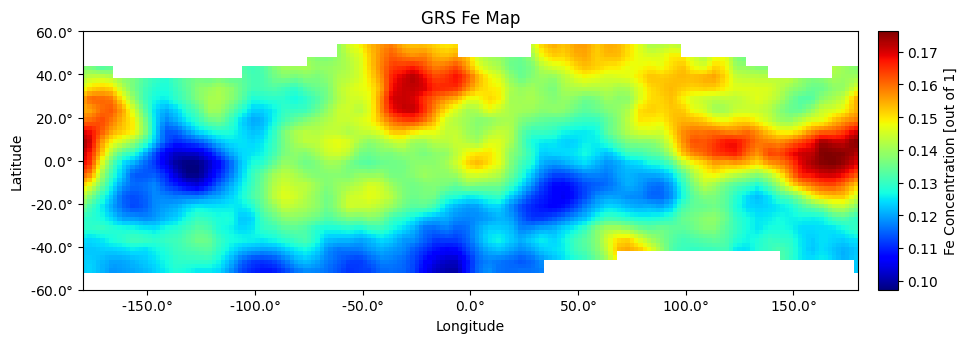

In [140]:
lon_left, lon_right = -180, 180
lat_bottom, lat_top = -60, 60

element_name = 'fe'
quantity = 'concentration'
grid_spacing = 2



# import time
# iterations = 10
# t0 = time.time()
# for i in range(iterations):


def plotThis(lon, lat):
    val = getConcentration(lon, lat, element_name=element_name, normalized=True, quantity=quantity)
    return val

dat = [[
    plotThis(lon,lat)
    for lon in np.arange(lon_left, lon_right, grid_spacing)]
    for lat in np.arange(lat_bottom, lat_top, grid_spacing)]


# t1 = time.time()
# total1 = (t1-t0)/iterations
# print(f'Time elapsed: {total1} seconds.')
# print(f'speed changed by factor of {total2/total1}')



'''apply mask'''
dat = np.asarray(dat)
dat = np.ma.masked_where((dat < 0), dat)



'''primary plot'''
fig = plt.figure(figsize=(10,7))
ax = plt.axes()
im = ax.imshow(dat[::-1], cmap='jet', extent=[lon_left, lon_right, lat_bottom, lat_top])

'''titles'''
ax.set_title(f'GRS {chem_casing(element_name)} Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

'''axis formatter'''
ax.xaxis.set_major_formatter('{x}$\degree$')
ax.yaxis.set_major_formatter('{x}$\degree$')


'''x ticks'''
'''Option 1: Set the spacing between x ticks'''
# x_spacing = 60
# ax.set_xticks(np.linspace(lon_left, lon_right, int((lon_right-lon_left)/x_spacing)+1))
'''Option 2: Set the number of x ticks'''
# x_ticks = 7
# ax.set_xticks(np.linspace(lon_left, lon_right, x_ticks))

'''y ticks'''
'''Option 1: Set the spacing between y ticks'''
# y_spacing = 25
# ax.set_yticks(np.linspace(lat_bottom, lat_top, int((lat_top-lat_bottom)/y_spacing)+1))
'''Option 2: Set the number of y ticks'''
# y_ticks = 7
# ax.set_yticks(np.linspace(lat_bottom, lat_top, y_ticks))

'''color bar'''
cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(f'{chem_casing(element_name)} Concentration [out of 1]', y=0.5)

plt.show()

---
# 2. Serialize + Save Data

Serializing with `pickle` has been depracated due to security risks.

In [8]:
path__dataDir = utils.getPath(path__rpDataHome, 'GRS', '2_ready_to_use', 'included_with_package')

In [9]:
os.makedirs(path__dataDir, exist_ok=True)

# iterate through keys and values of a nested dictionary
for element_name, element_dict in meta_dat.items():
    for quantity, dat in element_dict.items():
        filename = f'{element_name}_{quantity}.npy'
        np.save(utils.getPath(path__dataDir, filename), dat)

---
# 3. Load Serialized Data

In [12]:
meta_dat_test = {}

for file in os.listdir(path__dataDir):
    element_name = file[:file.index('_')].lower()
    quantity_name = file[file.index('_')+1:file.index('.')]
    if element_name not in meta_dat_test.keys():
        meta_dat_test[element_name] = {}
    meta_dat_test[element_name][quantity_name] = np.load(utils.getPath(path__dataDir, file))

In [14]:
def getConcentration_test(lon: float, lat: float, element_name: str, normalized: bool = True, quantity: str = 'concentration') -> float:
    # only change is that we use `meta_dat__pickled` instead of `meta_dat`
    
    """
    DESCRIPTION:
    ------------
        Get the concentration of an element at the desired coordinate derived from GRS data.
    
    PARAMETERS:
    ------------
        lon : float
            Longitude in range [-180, 180] (lon=0 cuts through Arabia Terra).
        lat : float
            Latitude in range [-87.5, 87.5].
        element_name : str
            Element for which you want to make a global concentration map. Options are ['al','ca','cl','fe','h2o','k','si','s','th']. Casing does not matter.
        normalized : bool (default True)
            If True, normalize to a volatile-free (Cl, H2O, S) basis.
                > "For such measurement [from GRS] to represent the bulk chemistry of the martian upper crust, it must be normalized to a volatile-free basis (22). That equates to a 7 to 14% increase in the K, Th, and U abundances (22), which we applied to the chemical maps by renormalizing to Cl, stoichiometric H2O, and S-free basis."
                Source: "Groundwater production from geothermal heating on early Mars and implication for early martian habitability", Ojha et al. 2020, https://www.science.org/doi/10.1126/sciadv.abb1669                    

    RETURN:
    ------------
        float
            Surface concentration of an element at the desired coordinate, using bilinear interpolation if that coordinate is not precisely defined by the data
                - Units: a 5% concentration corresponds to a return value of 0.05.
                - If a nearby "pixel" (original 5x5 bin) is unresolved by GRS, just return the nanval.
                
    """

    def bilinear_interpolation(x: float, y: float, points: list) -> float:
        '''
        Credit: https://stackoverflow.com/a/8662355/22122546

        Interpolate (x,y) from values associated with four points.
        
        points: list
            four triplets:  (x, y, value).
        
        See formula at:  http://en.wikipedia.org/wiki/Bilinear_interpolation
        '''

        points = sorted(points)               # order points by x, then by y
        (x1, y1, q11), (_x1, y2, q12), (x2, _y1, q21), (_x2, _y2, q22) = points

        # if x1 != _x1 or x2 != _x2 or y1 != _y1 or y2 != _y2:
        #     raise ValueError('points do not form a rectangle')
        # if not x1 <= x <= x2 or not y1 <= y <= y2:
        #     raise ValueError('(x, y) not within the rectangle')

        return (q11 * (x2 - x) * (y2 - y) +
                q21 * (x - x1) * (y2 - y) +
                q12 * (x2 - x) * (y - y1) +
                q22 * (x - x1) * (y - y1)
            ) / ((x2 - x1) * (y2 - y1) + 0.0)
    





    checkCoords(lon, lat)
    


    if not normalized: # just return the bilinear interpolation on the raw data

        # since `lon_range_cycled` and `lat_range` are decreasing rather than increasing, we do some trickery on top of `np.searchsorted()` to get the desired indices.
        i_lon = lon_range_cycled.shape[0] - np.searchsorted(np.flip(lon_range_cycled), lon)
        j_lat = lat_range.shape[0] - np.searchsorted(np.flip(lat_range), lat)

        element_name_lower = element_name.lower()

        # points = (
        #     (
        #         lon_range_cycled[i_lon - 1],
        #         lat_range[j_lat - 1],
        #         meta_dat[element_name_lower][quantity][i_lon - 1, j_lat - 1]
        #     ),
        #     (
        #         lon_range_cycled[i_lon],
        #         lat_range[j_lat - 1],
        #         meta_dat[element_name_lower][quantity][i_lon, j_lat - 1]
        #     ),
        #     (
        #         lon_range_cycled[i_lon - 1],
        #         lat_range[j_lat],
        #         meta_dat[element_name_lower][quantity][i_lon - 1, j_lat]
        #     ),
        #     (
        #         lon_range_cycled[i_lon],
        #         lat_range[j_lat],
        #         meta_dat[element_name_lower][quantity][i_lon, j_lat]
        #     )
        # )


        ###alternative version to the above that uses list comprehension as opposed to hard-coding -- functionally equivalent
        points = [
            (
                lon_range_cycled[i_lon-1+i],
                lat_range[j_lat-1+j],
                meta_dat_test[element_name][quantity][i_lon-1+i, j_lat-1+j]
            )
            for i, j in [(i, j) for i in range(2) for j in range(2)]
        ]
        

        return bilinear_interpolation(lon, lat, points)
    
    
    else: # see docstring for more details on `normalize=True` parameter

        volatiles = ["cl", "h2o", "s"]
        if element_name in volatiles:
            raise Exception('Cannot normalize a volatile to a volatile-free basis.')
        
        raw_concentration = getConcentration(lon, lat, element_name=element_name, normalized=False, quantity=quantity)
        
        sum_volatile_concentration = 0
        for volatile in volatiles:
            volatile_concentration = getConcentration(lon, lat, element_name=volatile, normalized=False, quantity=quantity)
            if volatile_concentration < 0:
                return get_nanval()
            sum_volatile_concentration += volatile_concentration

        return raw_concentration/(1-sum_volatile_concentration)

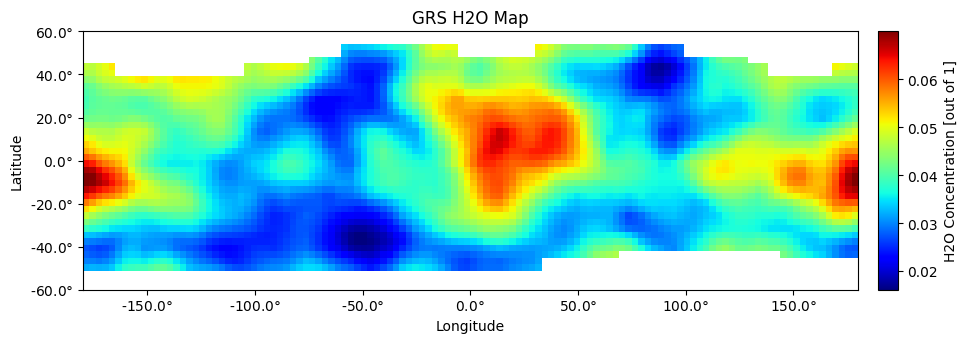

In [15]:
dat = []

lon_left = -180
lon_right = 180
lat_bottom = -60
lat_top = 60

element_name = 'h2o'
quantity = 'concentration'
grid_spacing = 3


for lat in np.arange(lat_bottom, lat_top, grid_spacing):
    newline = []
    for lon in np.arange(lon_left, lon_right, grid_spacing):

        '''modify this line to change value being plotted'''
        val = getConcentration_test(lon, lat, element_name=element_name, normalized=False, quantity=quantity)

        newline.append(val)
    dat.append(newline)


'''apply mask'''
dat = np.asarray(dat)
dat = np.ma.masked_where((dat <= 0), dat)



'''primary plot'''
fig = plt.figure(figsize=(10,7))
ax = plt.axes()
im = ax.imshow(dat[::-1], cmap='jet', extent=[lon_left, lon_right, lat_bottom, lat_top])

'''titles'''
ax.set_title(f'GRS {chem_casing(element_name)} Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

'''axis formatter'''
ax.xaxis.set_major_formatter('{x}$\degree$')
ax.yaxis.set_major_formatter('{x}$\degree$')


'''x ticks'''
'''Option 1: Set the spacing between x ticks'''
# x_spacing = 60
# ax.set_xticks(np.linspace(lon_left, lon_right, int((lon_right-lon_left)/x_spacing)+1))
'''Option 2: Set the number of x ticks'''
# x_ticks = 7
# ax.set_xticks(np.linspace(lon_left, lon_right, x_ticks))

'''y ticks'''
'''Option 1: Set the spacing between y ticks'''
# y_spacing = 25
# ax.set_yticks(np.linspace(lat_bottom, lat_top, int((lat_top-lat_bottom)/y_spacing)+1))
'''Option 2: Set the number of y ticks'''
# y_ticks = 7
# ax.set_yticks(np.linspace(lat_bottom, lat_top, y_ticks))

'''color bar'''
cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(f'{chem_casing(element_name)} Concentration [out of 1]', y=0.5)

plt.show()

---
# 4. Optional: Test Class

In [1]:
from redplanet import GRS

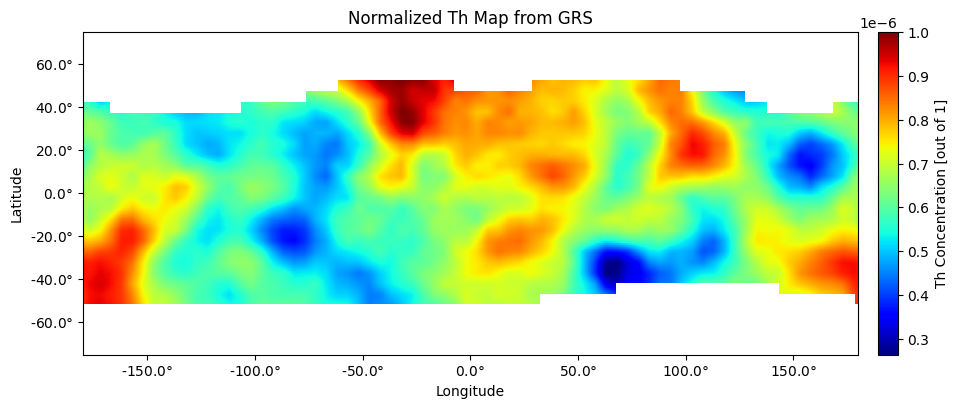

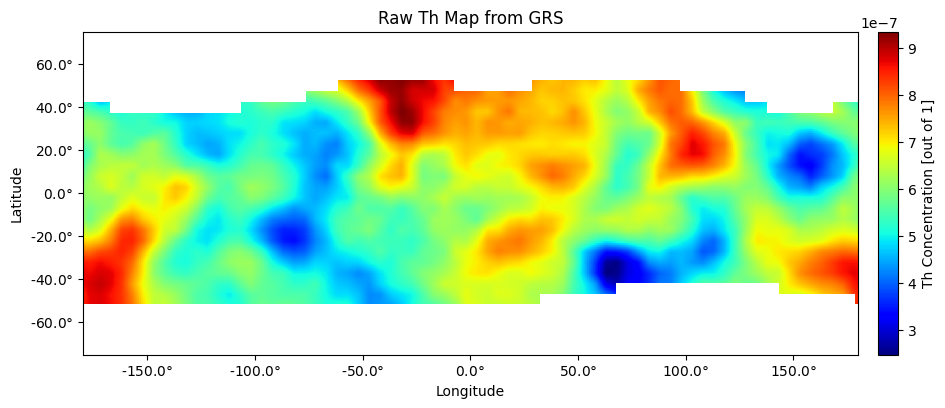

In [4]:
GRS.visualize('th', grid_spacing=1, normalize=True)
GRS.visualize('th', grid_spacing=1, normalize=False)